In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import pywt
import torch.optim as optim
import glob
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 检查CUDA是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Data_path = '/home/ubuntu/data/workspace/Li/Data/'
save_path = '/home/ubuntu/data/workspace/Li/Python_nonlinear_verification4/'

Using device: cuda:0


In [3]:
M = 9900
A = 1
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = f'{Data_path}Hanning_Signal_Experiment(10000)'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 从文件名中提取x, y, z, j, k标签
    filename = os.path.basename(dataPath)
    parts = filename.split('_')
    # 假设文件名格式为 "x_y_z_j_k.csv"
    k = int(parts[-1].split('.')[0])  # 提取文件名中最后一个部分（k），并去掉.csv扩展名

    # 读取数据
    data_1 = pd.read_csv(dataPath)
    # 提取标签
    label1_force = parts[0]
    label2_HI = parts[1]
    label1 = float(label1_force)
    label2 = float(label2_HI)
    labels.append([label1, label2])

    # 检查第一列的每一行，找到第一个大于0的值的位置N
    for N in range(len(data_1)):
        if data_1.iloc[N, 1] != 0:
            break

    # 如果找到了大于0的值，则从第二列的第N行开始，往后取M个点
    if N < len(data_1) - M + 1:  # 确保N+M不会超出索引范围
        data.append(data_1.iloc[N:N+M, 1].values)

# 将数据和标签转换为numpy数组
all_datas = np.array(data, dtype="float")
all_labels = np.array(labels)

# 直接按照7:2:1的比例划分
# 首先分出训练集（70%）和临时集（30%）
train_datas, temp_datas, train_labels, temp_labels = train_test_split(
    all_datas, all_labels, test_size = 0.3, random_state=42
)

# 然后将临时集按照2:1的比例划分为验证集和测试集
# 2:1相当于验证集占2/3，测试集占1/3
validation_datas, test_data, validation_labels, test_labels = train_test_split(
    temp_datas, temp_labels, test_size=1/2, random_state=42
)

# 输出数据集的形状以确认
print("训练集数据形状:", train_datas.shape)
print("验证集数据形状:", validation_datas.shape)
print("测试集数据形状:", test_data.shape)

训练集数据形状: (911, 9900)
验证集数据形状: (195, 9900)
测试集数据形状: (196, 9900)


In [4]:
test_datas = test_data.reshape(-1,test_data.shape[1],1)
print(test_datas.shape)

(196, 9900, 1)


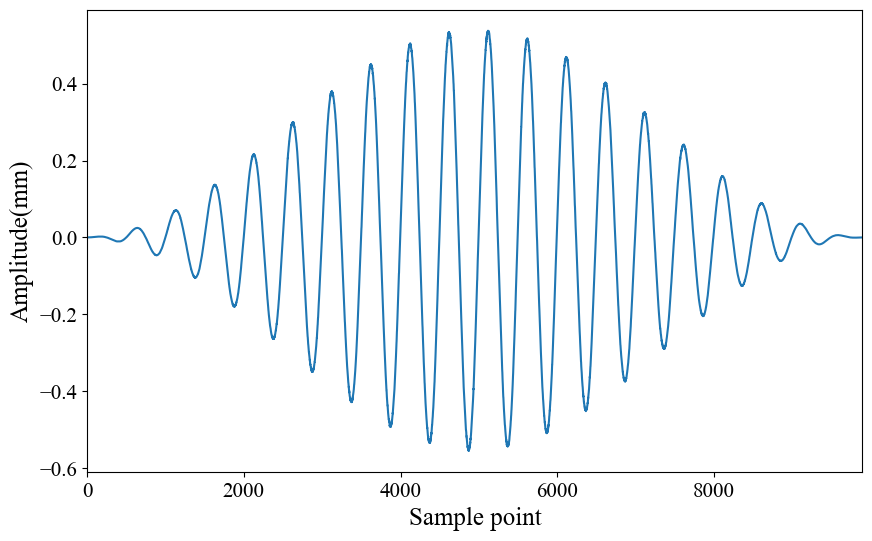

In [5]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(test_datas[9],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim([0,M])
plt.savefig(f'{save_path}test_data.jpg', dpi=600, bbox_inches='tight')

In [6]:
BATCH_SIZE = 1
input_size = 9301
hidden_size = 128
num_layers = 2
output_size = 2

In [7]:
test_dataset = TensorDataset(torch.from_numpy(test_datas),torch.from_numpy(test_labels))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class ConvAutoencoderPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(ConvAutoencoderPredictor, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)  # 添加 Dropout 层
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=input_size, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # 添加 Dropout 层
        )
        # 双向LSTM
        self.bdlstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        # 预测层
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 由于是双向LSTM，所以输出维度是hidden_size * 2
        self.dropout = nn.Dropout(dropout_rate)  # 添加 Dropout 层

    def forward(self, x):
        wavelet = 'db4'
        # 将张量移动至CPU上面
        x1 = x.cpu()

        # 将CPU张量转化为numpy
        x2 = x1.numpy()
        # 离散小波分解
        coeffs = pywt.wavedec(x2, wavelet, level=6)
        xh1 = coeffs[6]
        xh2 = coeffs[5]
        xh3 = coeffs[4]
        xh4 = coeffs[3]
        xh5 = coeffs[2]
        xh6 = coeffs[1]
        xl6 = coeffs[0]
        # 连接分解后的序列
        x3 = np.concatenate((xh1, xh2, xh3, xh4), axis=-1)

        x4 = torch.from_numpy(x3)
        x5 = x4.to(device)

        x6 = x5.permute(0, 2, 1)  # 调整维度以适应卷积层 [batch_size, num_features, seq_length]

        encoded = self.encoder(x6)
        
        decoded = self.decoder(encoded)

        out = decoded.view(decoded.size(0), -1)  # 展平
        out = out.view(out.size(0), -1, input_size)  # 调整维度以适应LSTM [batch_size, seq_length, input_size]

        lstm_out, _ = self.bdlstm(out)  # LSTM输出
        lstm_out = lstm_out[:, -1, :]  # 取LSTM最后一个时间步的输出

        out = self.dropout(lstm_out)  # 在 LSTM 输出后添加 Dropout
        out = self.fc(out)
        return out

In [9]:
model = ConvAutoencoderPredictor(input_size, hidden_size, output_size, num_layers,dropout_rate = 0.5)
model.load_state_dict(torch.load(f'{save_path}/Inverse_Model.pth'))
model.to(device)

ConvAutoencoderPredictor(
  (encoder): Sequential(
    (0): Conv1d(9301, 64, kernel_size=(1,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
    (1): ReLU()
    (2): ConvTranspose1d(64, 9301, kernel_size=(2,), stride=(2,))
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (bdlstm): LSTM(9301, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
# 将模型设置为评估模式
model.eval()  
# 进行预测

force_test=[]
HI_test=[]

force_pred = []
HI_pred = []
for i, (x, y) in enumerate(test_loader):

    x1=x.type(torch.FloatTensor)
    x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换
    x3,y=x2.to(device),y.to(device)
    
    force = y[:,0]
    HI = y[:,1]

    force_test.append(force.item())
    HI_test.append(HI.item())

    with torch.no_grad():  # 关闭梯度计算
        outputs = model(x3)
        force_pred.append(outputs[:,0].item())
        HI_pred.append(outputs[:,1].item())

In [11]:
force_pred1 = np.array(force_pred)

HI_pred1 = np.array(HI_pred)

from sklearn.metrics import r2_score
r2_force = r2_score(test_labels[:,0], force_pred1)
print(f'R² Score for force: {r2_force:.2f}')

r2_HI = r2_score(test_labels[:,1], HI_pred1)
print(f'R² Score for HI: {r2_HI:.2f}')

R² Score for force: 0.62
R² Score for HI: 0.59


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_force = mean_squared_error(test_labels[:,0], force_pred)
print(f'MSE_force: {mse_force:.3f}:')

mse_HI = mean_squared_error(test_labels[:,1], HI_pred)
print(f'MSE_HI: {mse_HI:.3f}:')

# 计算 MAE
mae_force = mean_absolute_error(test_labels[:,0], force_pred)
print(f'MAE_force: {mae_force:.3f}')

mae_HI = mean_absolute_error(test_labels[:,1], HI_pred)
print(f'MAE_HI: {mae_HI:.3f}')

MSE_force: 15.646:
MSE_HI: 0.015:
MAE_force: 2.095
MAE_HI: 0.067


In [13]:
def mape(y_true, y_pred):
    n = len(y_true)
    if n == 0:
        return 0
    errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(errors) * 100

# test_labels是二维的numpy数组，[:, 0]表示取第一列作为长度相关的真实值
# force_pred是对应的长度预测值
mape_force = mape(test_labels[:, 0], force_pred)
print(f'MAPE_force: {mape_force:.3f}')

mape_HI = mape(test_labels[:, 0], HI_pred)
print(f'MAPE_HI: {mape_HI:.3f}')

MAPE_force: 9.983
MAPE_HI: 97.094


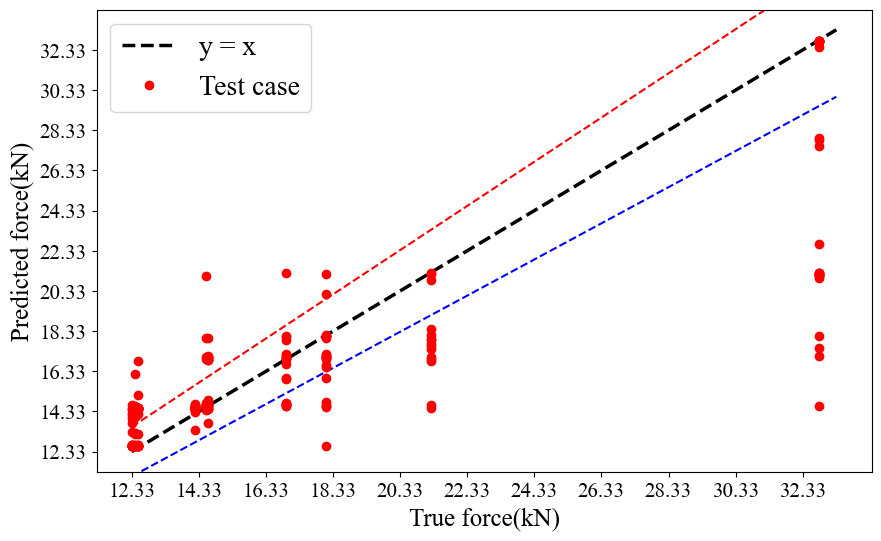

In [14]:
# 绘图命令
plt.style.use('default')
plt.figure(figsize=(10, 6)) #创建Figure对象，并指定尺寸
plt.rcParams['font.family'] = ['Times New Roman']
force_true=np.arange(np.min(test_labels[:,0]),np.max(test_labels[:,0])+1,0.5)
plt.plot(force_true,force_true,'k--', label='y = x',linewidth=2.5)

plt.plot(force_true, 1.1*force_true,'r--',linewidth=1.5)
plt.plot(force_true, 0.9*force_true,'b--',linewidth=1.5)

# 绘制红色实心圆
plt.plot(test_labels[:,0],force_pred1, marker='o', markersize=6, color='red', linestyle='None',label='Test case')

#plt.text(8, 2, f'R\u00B2={r2:.2f}', fontsize=20, color='black')  # 在坐标 (2, 0) 位置插入文本

plt.xlabel('True force(kN)',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Predicted force(kN)',fontdict={'weight': 'normal', 'size': 18})

# 设置坐标轴刻度
plt.xticks(np.arange(force_true.min(),force_true.max()+1,2))  
plt.yticks(np.arange(force_true.min(),force_true.max()+1,2)) 

plt.ylim([force_true.min()-1, force_true.max()+1]) 

#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15) 

plt.legend(fontsize=20)

plt.savefig(f'{save_path}Force_precidtion.jpg', dpi=600, bbox_inches='tight')

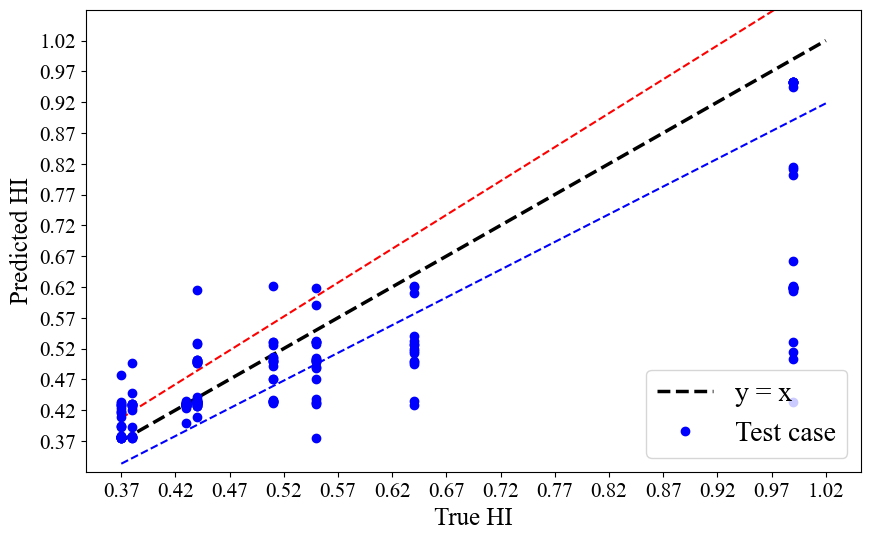

In [15]:
# 绘图命令
plt.style.use('default')
plt.figure(figsize=(10, 6)) #创建Figure对象，并指定尺寸
plt.rcParams['font.family'] = ['Times New Roman']
HI_true=np.arange(np.min(test_labels[:,1]),np.max(test_labels[:,1])+0.05,0.05)
plt.plot(HI_true,HI_true,'k--', label='y = x',linewidth=2.5)

plt.plot(HI_true, 1.1*HI_true,'r--',linewidth=1.5)
plt.plot(HI_true, 0.9*HI_true,'b--',linewidth=1.5)

# 绘制红色实心圆
plt.plot(test_labels[:,1],HI_pred1, marker='o', markersize=6, color='blue', linestyle='None',label='Test case')

#plt.text(8, 2, f'R\u00B2={r2:.2f}', fontsize=20, color='black')  # 在坐标 (2, 0) 位置插入文本

plt.xlabel('True HI',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Predicted HI',fontdict={'weight': 'normal', 'size': 18})

# 设置坐标轴刻度
plt.xticks(np.arange(HI_true.min(),HI_true.max()+0.05,0.05))  
plt.yticks(np.arange(HI_true.min(),HI_true.max()+0.05,0.05))

plt.ylim([HI_true.min()-0.05, HI_true.max()+0.05]) 

#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15) 

plt.legend(fontsize=20,loc='lower right')

plt.savefig(f'{save_path}HI_precidtion.jpg', dpi=600, bbox_inches='tight')